# Hiragana
use CNN to learn and recognize hiragana


## Imports

In [1]:
!python --version

Python 3.11.9


In [2]:
import numpy as np
import tensorflow as tf
print("NumPy version: ", np.__version__)
print("TensorFlow version: ", tf.__version__)


2024-06-23 22:24:41.515036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 22:24:42.143094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NumPy version:  1.26.4
TensorFlow version:  2.16.1


In [3]:
## check available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-06-23 22:24:42.918542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 22:24:42.965575: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import random, math, os

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical  # replaces to_categorical
from tensorflow.keras.callbacks import EarlyStopping


## Data Input and Organization

In [5]:
## Load the dataset
from organize_data import download_hiragana_dataset

download_hiragana_dataset()

In [6]:
## import data into a list
## construct datatable
from organize_data import create_handwriting_table

handwriting_table = create_handwriting_table()
handwriting_table.head()

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSO11.jpg,so
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaNI12.jpg,ni
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSA16.jpg,sa
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSU2.jpg,su
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaTSU8.jpg,tsu


### Image preprocess


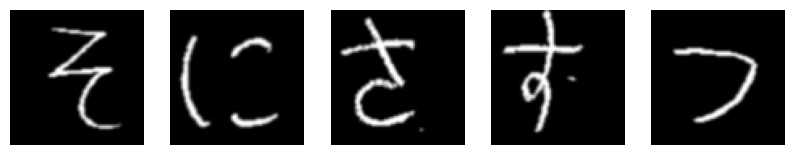

In [7]:
# show the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table.Handwriting[i], cmap='gray')
    ax[i].axis('off')

In [8]:
## process images with threshold = 40
from image_process import im_clean, im_bin, im_reshape, IMG_SIZE
img_rows, img_cols = IMG_SIZE
handwriting_table.Handwriting = handwriting_table.Handwriting.map(lambda img: im_reshape(im_clean(img), img_rows, img_cols))

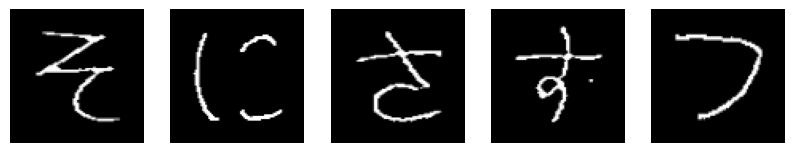

In [9]:
# show the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table.Handwriting[i], cmap='gray')
    ax[i].axis('off')

In [10]:
handwriting_table.Handwriting[0].shape

(84, 84)

### Import another dataset
Import a new dataset created by Wishyut.

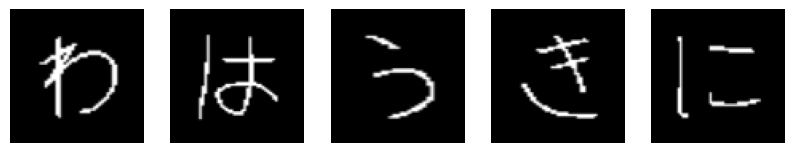

In [11]:
from organize_data import get_handwriting_wishyut
handwriting_table_wishyut = get_handwriting_wishyut()

fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(handwriting_table_wishyut.Handwriting[i], cmap='gray')
    ax[i].axis('off')

Organizing Romanji labels
* Organize the different labels with the same pronunciation

In [12]:
# create a function that maps {'hu', 'si', 'ti', 'tu'} to {'fu', 'shi', 'chi', 'tsu'}
from label_process import map_to_hiragana
# apply the function to the Romanji column
handwriting_table.Romanji = handwriting_table.Romanji.map(map_to_hiragana)
handwriting_table_wishyut.Romanji = handwriting_table_wishyut.Romanji.map(map_to_hiragana)

In [13]:
## combine two tables
# handwriting_table = handwriting_table.append(handwriting_table_wishyut, ignore_index=True) # old!
handwriting_table = pd.concat([handwriting_table, handwriting_table_wishyut])
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSO11.jpg,so
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaNI12.jpg,ni
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSA16.jpg,sa
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSU2.jpg,su
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaTSU8.jpg,tsu
...,...,...,...
400,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_te_3.png,te
401,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_ma_1.png,ma
402,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_ko_9.png,ko
403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_ke_8.png,ke


### Add numerical label to each Romanji (for categorization)

In [14]:
## add labels to the datatable w.r.t. the romanji
from label_process import romanji_to_dict

romanji_dict = romanji_to_dict(handwriting_table["Romanji"])
romanji_categories = len(romanji_dict)
handwriting_table["Label"] = handwriting_table["Romanji"].map(lambda x: romanji_dict[x])

print(romanji_dict)
print(romanji_categories)
handwriting_table.head()

{'fu': 0, 'mi': 1, 'i': 2, 'su': 3, 'to': 4, 'ya': 5, 'se': 6, 'o': 7, 'shi': 8, 'ro': 9, 'na': 10, 'ru': 11, 'chi': 12, 'a': 13, 're': 14, 'ma': 15, 'me': 16, 'da': 17, 'hi': 18, 'mo': 19, 'ku': 20, 'ri': 21, 'ta': 22, 'ka': 23, 'mu': 24, 'ne': 25, 'pi': 26, 'ko': 27, 'ra': 28, 'wa': 29, 'n': 30, 'tsu': 31, 'ha': 32, 'he': 33, 'sa': 34, 'e': 35, 'u': 36, 'ki': 37, 'ba': 38, 'no': 39, 'ji': 40, 'wo': 41, 'ni': 42, 'so': 43, 'ho': 44, 'te': 45, 'nu': 46, 'ke': 47, 'yu': 48, 'yo': 49}
50


,Handwriting,Filename,Romanji,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSO11.jpg,so,43
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaNI12.jpg,ni,42
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSA16.jpg,sa,34
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaSU2.jpg,su,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaTSU8.jpg,tsu,31


In [15]:
## construct X and y data from data-table
X = handwriting_table["Handwriting"].to_numpy()
y = handwriting_table["Label"].to_numpy()

# X = np.array([X[i].reshape(img_rows, img_cols) for i in range(X.shape[0])])
# X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = np.concatenate(X).reshape(-1, img_rows, img_cols, 1)
X.shape

(1405, 84, 84, 1)

In [16]:
## split the data into training and testing data + one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y) # , shuffle=True
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train) # , shuffle=True

Y_train_train = to_categorical(y_train_train, romanji_categories)
Y_val = to_categorical(y_val, romanji_categories)
Y_test = to_categorical(y_test, romanji_categories)

X_train.shape

(1194, 84, 84, 1)

### Standardization
standardize the strength of each pixel from 0-255 to 0-1

In [17]:
## standardize X_train and X_test
from organize_data import std_X

X_train_train = std_X(X_train_train)
X_val = std_X(X_val)
X_test = std_X(X_test)

## CNN Model
Construct a CNN model with two convolution blocks, one flattening, and one dense layers.
* Each convolution block contains two convolution layers and a maxpooling layer.

In [18]:
from ml_model import build_hiragana_cnn

input_shape = (img_rows, img_cols, 1)
model = build_hiragana_cnn(input_shape, romanji_categories)

print('model.summary:')
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy', 'f1_score'])

model.summary:


/home/physics/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,225,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,303,442 (27.86 MB)

 Trainable params: 7,303,442 (27.86 MB)

 Non-trainable params: 0 (0.00 B)

### Augmentation
Use the augmentation to generate more data from the training data.
* Use rotate and shear transform to simulate all kinds of handwritings.

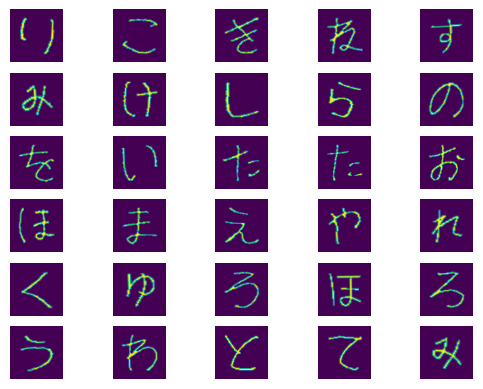

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Range for picking a value from.
datagen = ImageDataGenerator(
    rotation_range=5,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    shear_range=0.1,
    # zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2)


i = 0
for batch in datagen.flow(X_train_train, batch_size=1):
    plt.subplot(6,5,1 + i)
    plt.axis("off")
    
    augImage = batch[0]
    augImage = augImage.astype('float32')
    augImage /= 255
    plt.imshow(augImage)
    
    i += 1
    if i > 29:
        break

### Training

In [20]:
## train the model wuth data (including augmentaion datagen)
batch_size = 256  #128
nb_epoch = 16

# fits the model on batches with real-time data augmentation:
train_history = model.fit(datagen.flow(X_train_train, Y_train_train, batch_size=32),
         validation_data=(X_val, Y_val),
         batch_size=batch_size, epochs=nb_epoch, verbose=1,
         callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))


Epoch 1/16


/home/physics/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - accuracy: 0.2163 - f1_score: 0.2119 - loss: 3.2052 - val_accuracy: 0.8889 - val_f1_score: 0.8908 - val_loss: 0.4902
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.9028 - f1_score: 0.8652 - loss: 0.3851 - val_accuracy: 0.9333 - val_f1_score: 0.9289 - val_loss: 0.3009
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.9557 - f1_score: 0.9294 - loss: 0.1852 - val_accuracy: 0.9333 - val_f1_score: 0.9347 - val_loss: 0.3088
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9886 - f1_score: 0.9655 - loss: 0.0504 - val_accuracy: 0.9500 - val_f1_score: 0.9493 - val_loss: 0.3089
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9911 - f1_score: 0.9635 - loss: 0.0344 - val_accuracy: 0.9333 - val_f1_score: 0.9327 - val_loss: 0.5001
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.9825 - f1_score: 0.9505 - loss: 0.0575 - val_accuracy: 0.9389 - val_f1_score: 0.9315 - va

Plot the training process.

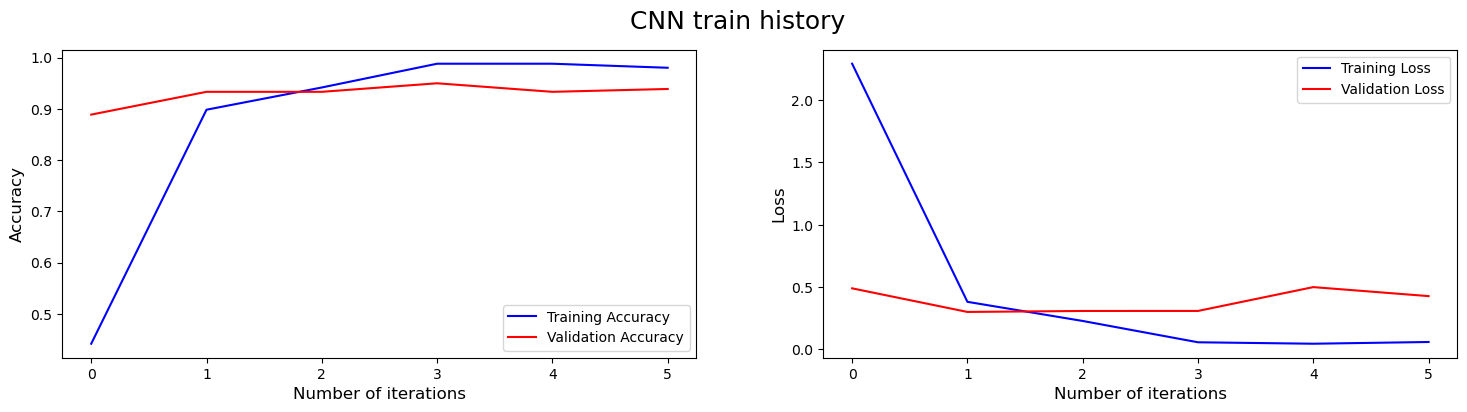

In [21]:
## plot train history
from demonstration import plot_train_history

plot_train_history(train_history)

## Model Evaluation
Evaluate the model with testing data.

In [22]:
# from tensorflow.keras.metrics import f1_score

score = model.evaluate(X_test, Y_test, verbose=1, return_dict=True)
# score
print('Test accuracy:', score['accuracy'])
print('Test f1_score:', score['f1_score'].numpy().mean())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9176 - f1_score: 0.8232 - loss: 0.3729
Test accuracy: 0.9241706132888794
Test f1_score: 0.9283831


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
total testing data: 211
Number of errors = 16/211
Accuracy: 0.92


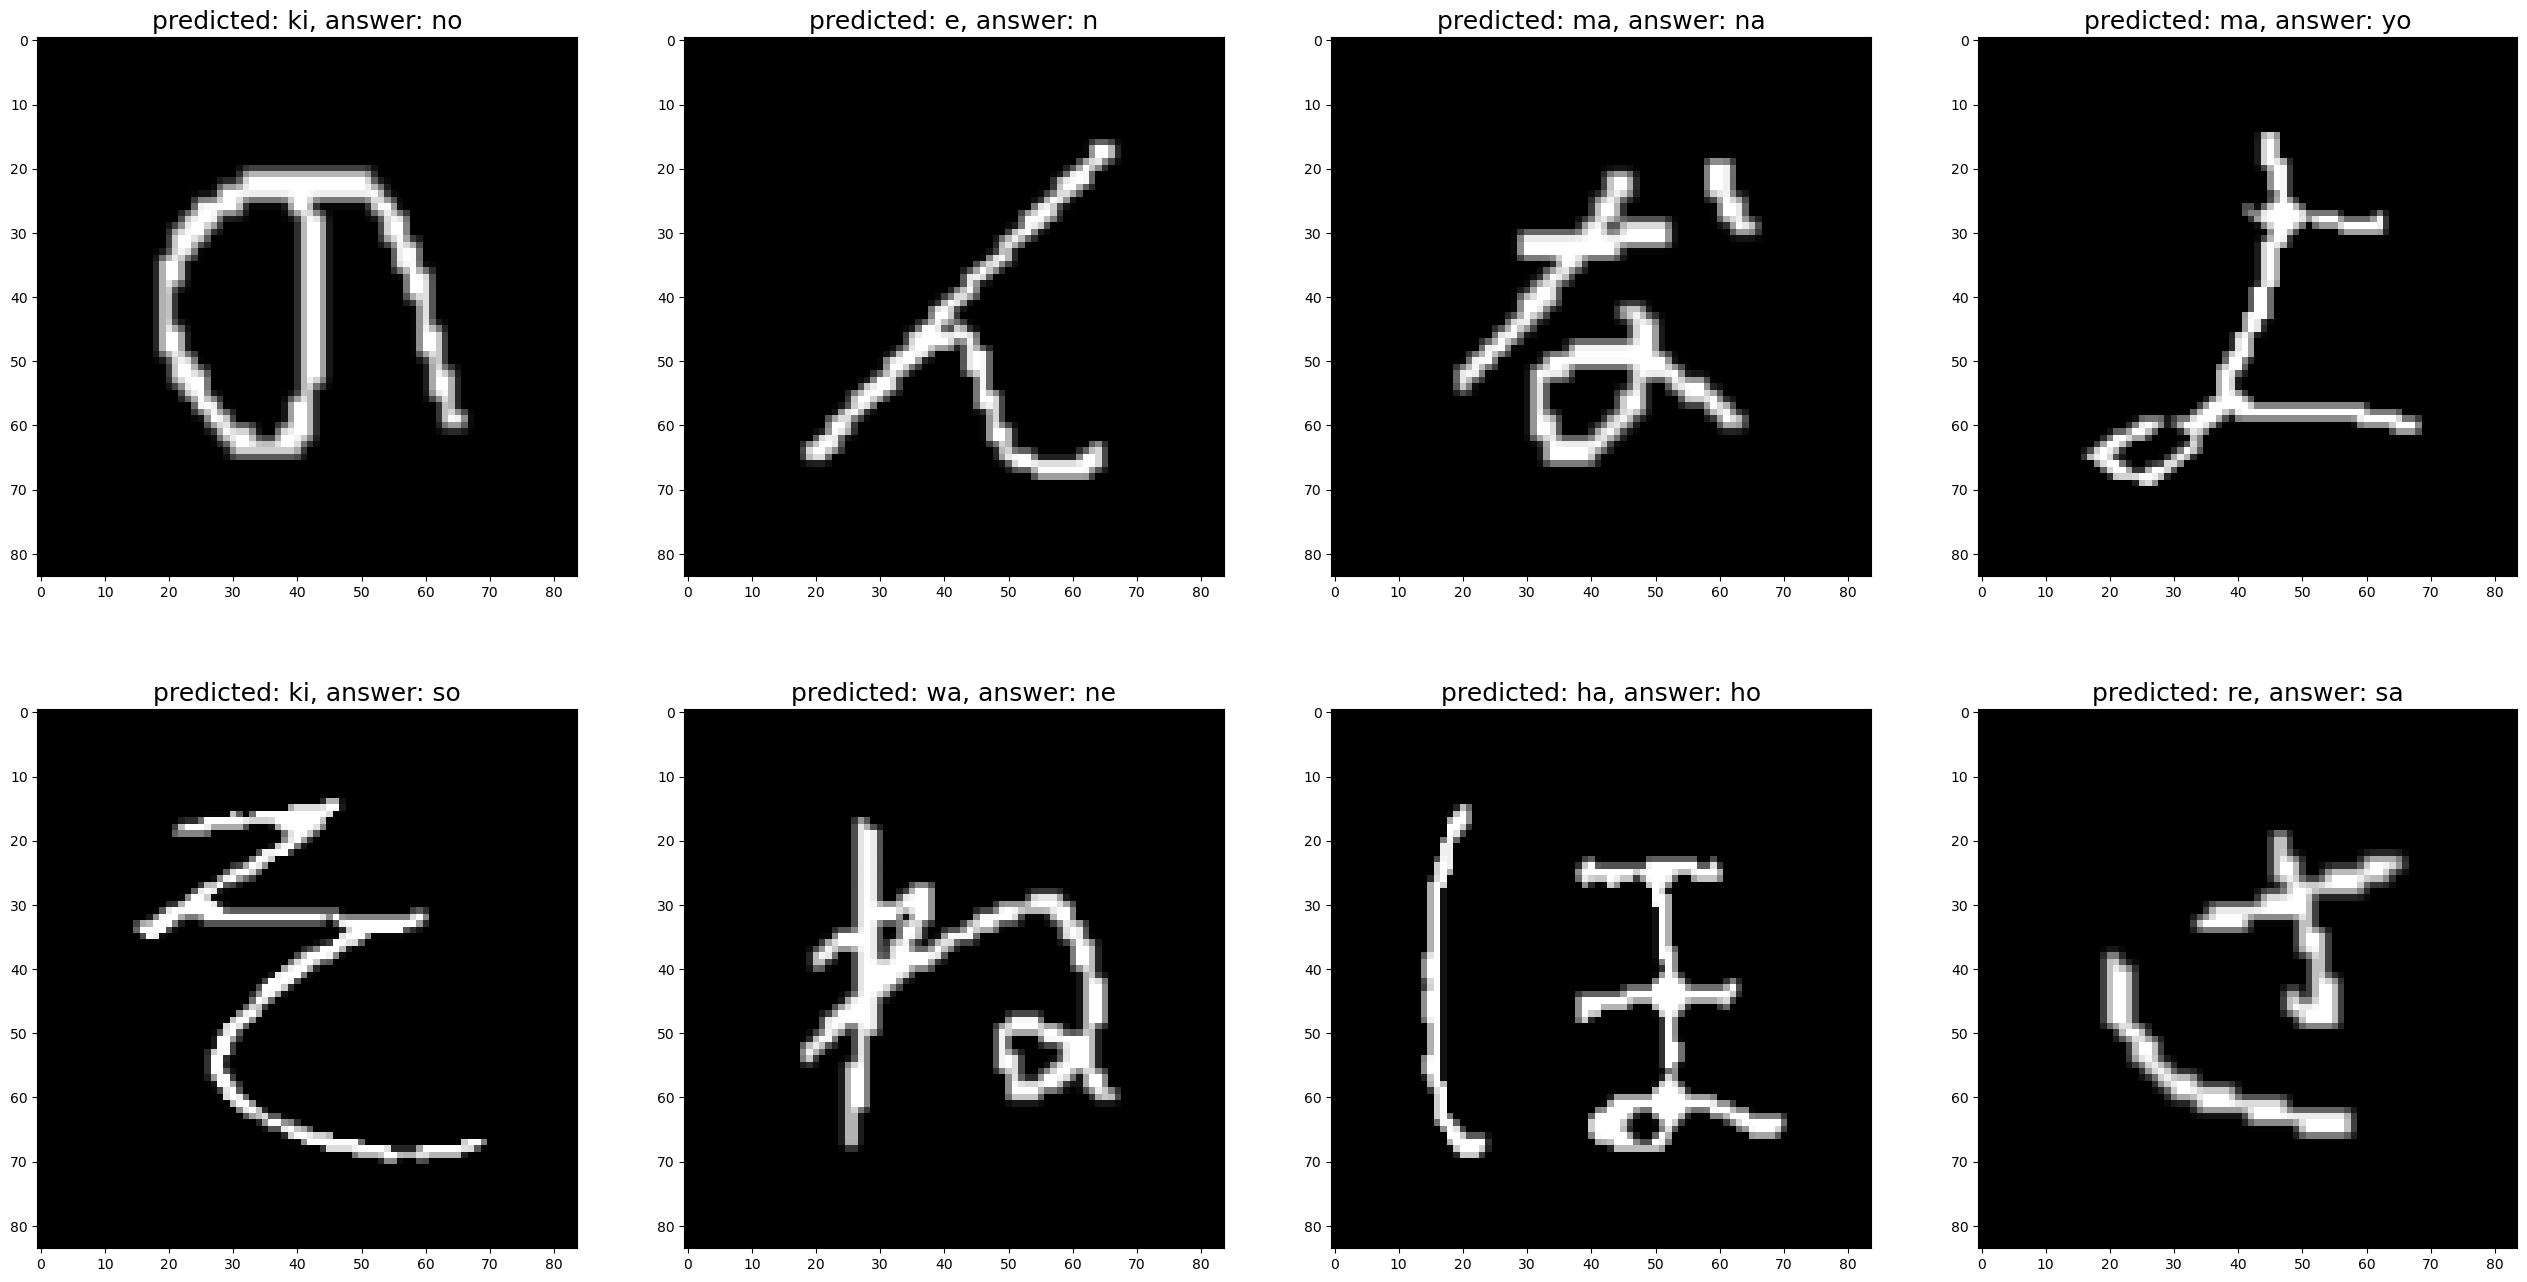

In [23]:
## show the (error) prediction results
from demonstration import get_predictions, show_errs

predictions = get_predictions(X_test, model)
ground_truth = y_test

show_errs(X_test, predictions, ground_truth, romanji_dict)

### Confusion matrix


In [24]:
confusion_matrix = np.zeros((romanji_categories, romanji_categories), dtype=np.uint8)

for predict, answer in zip(predictions, ground_truth):
    confusion_matrix[answer][predict] += 1
confusion_matrix


array([[4, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=uint8)

Confusion matrix, without normalization


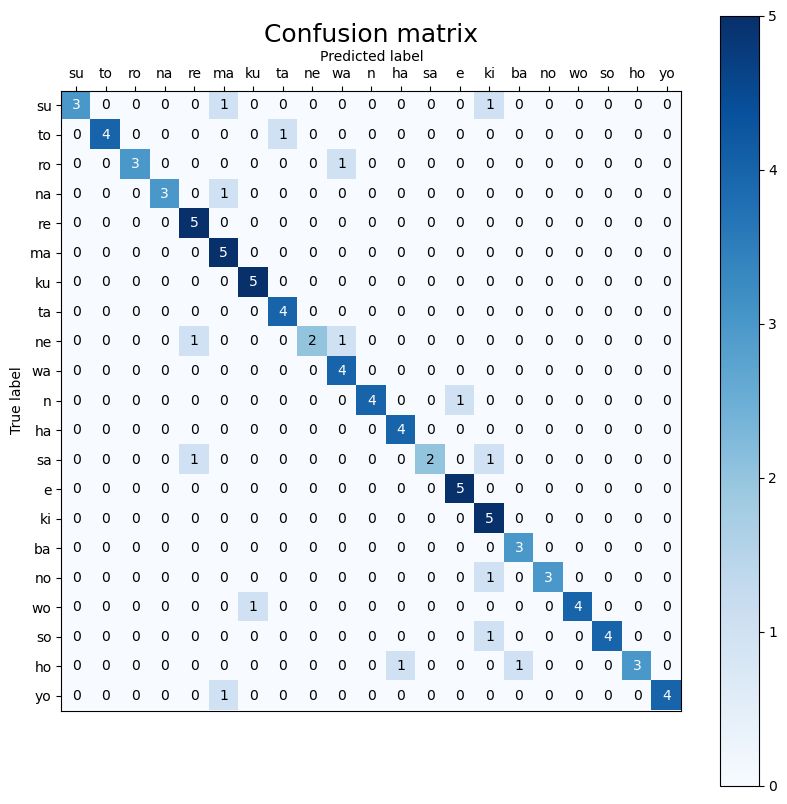

In [25]:
## plot confusion matrix (not normalized)
from demonstration import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix, romanji_dict,
                      title='Confusion matrix')


## Cross Valiadation

In [27]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True) # , random_state=42

metrics = []
models = []

for train_index, val_index in skf.split(X_train, y_train): # skf.split(X, y)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    Y_train_fold = to_categorical(y_train_fold, romanji_categories)
    Y_val_fold = to_categorical(y_val_fold, romanji_categories)

    X_train_fold = std_X(X_train_fold)
    X_val_fold = std_X(X_val_fold)

    model = build_hiragana_cnn(input_shape, romanji_categories)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy', 'f1_score'])
    
    train_history = model.fit(datagen.flow(X_train_fold, Y_train_fold, batch_size=32),
                                validation_data=(X_val_fold, Y_val_fold),
                                batch_size=batch_size, epochs=nb_epoch, verbose=0,
                                callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))
    
    score = model.evaluate(X_val_fold, Y_val_fold, verbose=1, return_dict=True)
    print('Validation loss:', score['loss'])
    print('Validation accuracy:', score['accuracy'])
    score['f1_score'] = score['f1_score'].numpy().mean()
    print('Validation f1_score:', score['f1_score'])
    metrics.append(score)
    models.append(model)


metrics = pd.DataFrame(metrics, columns=['loss', 'accuracy', 'f1_score'])
metrics


/home/physics/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/physics/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 6: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9262 - f1_score: 0.8243 - loss: 0.3683
Validation loss: 0.3665434420108795
Validation accuracy: 0.9246861934661865
Validation f1_score: 0.92503685
Epoch 10: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9525 - f1_score: 0.8528 - loss: 0.2140
Validation loss: 0.32235270738601685
Validation accuracy: 0.9497907757759094
Validation f1_score: 0.94850504
Epoch 8: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9631 - f1_score: 0.8730 - loss: 0.1746
Validation loss: 0.17226433753967285
Validation accuracy: 0.9665272235870361
Validation f1_score: 0.9675577
Epoch 16: early stopping
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9715 - f1_score: 0.8581 - loss: 0.1799
Validation loss: 0.1612609624862671
Validation accuracy: 0.9707112908363342
Validation f1_score: 0.9717287
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9797 - f1_score: 0.9083 - loss: 0.0553
Validation loss

,loss,accuracy,f1_score
0,0.366543,0.924686,0.925037
1,0.322353,0.949791,0.948505
2,0.172264,0.966527,0.967558
3,0.161261,0.970711,0.971729
4,0.070875,0.983193,0.983434


In [28]:
metrics.describe()

,loss,accuracy,f1_score
count,5.000000,5.000000,5.000000
mean,0.218659,0.958982,0.959252
std,0.122382,0.022591,0.022889
min,0.070875,0.924686,0.925037
25%,0.161261,0.949791,0.948505
50%,0.172264,0.966527,0.967558
75%,0.322353,0.970711,0.971729
max,0.366543,0.983193,0.983434


Our cross validation shows that this CNN model is reliable.

In [34]:
## decide the best model
model_vd = models[np.argmin(metrics['loss'])]
## evaluate the best model
score = model_vd.evaluate(X_test, Y_test, verbose=1, return_dict=True)
print('Test accuracy:', score['accuracy'])
print('Test f1_score:', score['f1_score'].numpy().mean())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9798 - f1_score: 0.8913 - loss: 0.1701
Test accuracy: 0.971563994884491
Test f1_score: 0.9731746


## Test My Handwritings
Write hiraganas with paint-2D.

Test my hiragana handwritings with the trained model.

In [30]:
from organize_data import load_my_handwritings

my_handwritings, answers_myhw = load_my_handwritings()
print(my_handwritings.shape)
print(answers_myhw[:5])

(92, 84, 84)
['i', 'o', 'hi', 'su', 'me']


In [31]:
my_handwritings = my_handwritings[..., np.newaxis]
my_handwritings = std_X(my_handwritings)
print(my_handwritings.shape)


(92, 84, 84, 1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
total testing data: 92
Number of errors = 21/92
Accuracy: 0.77


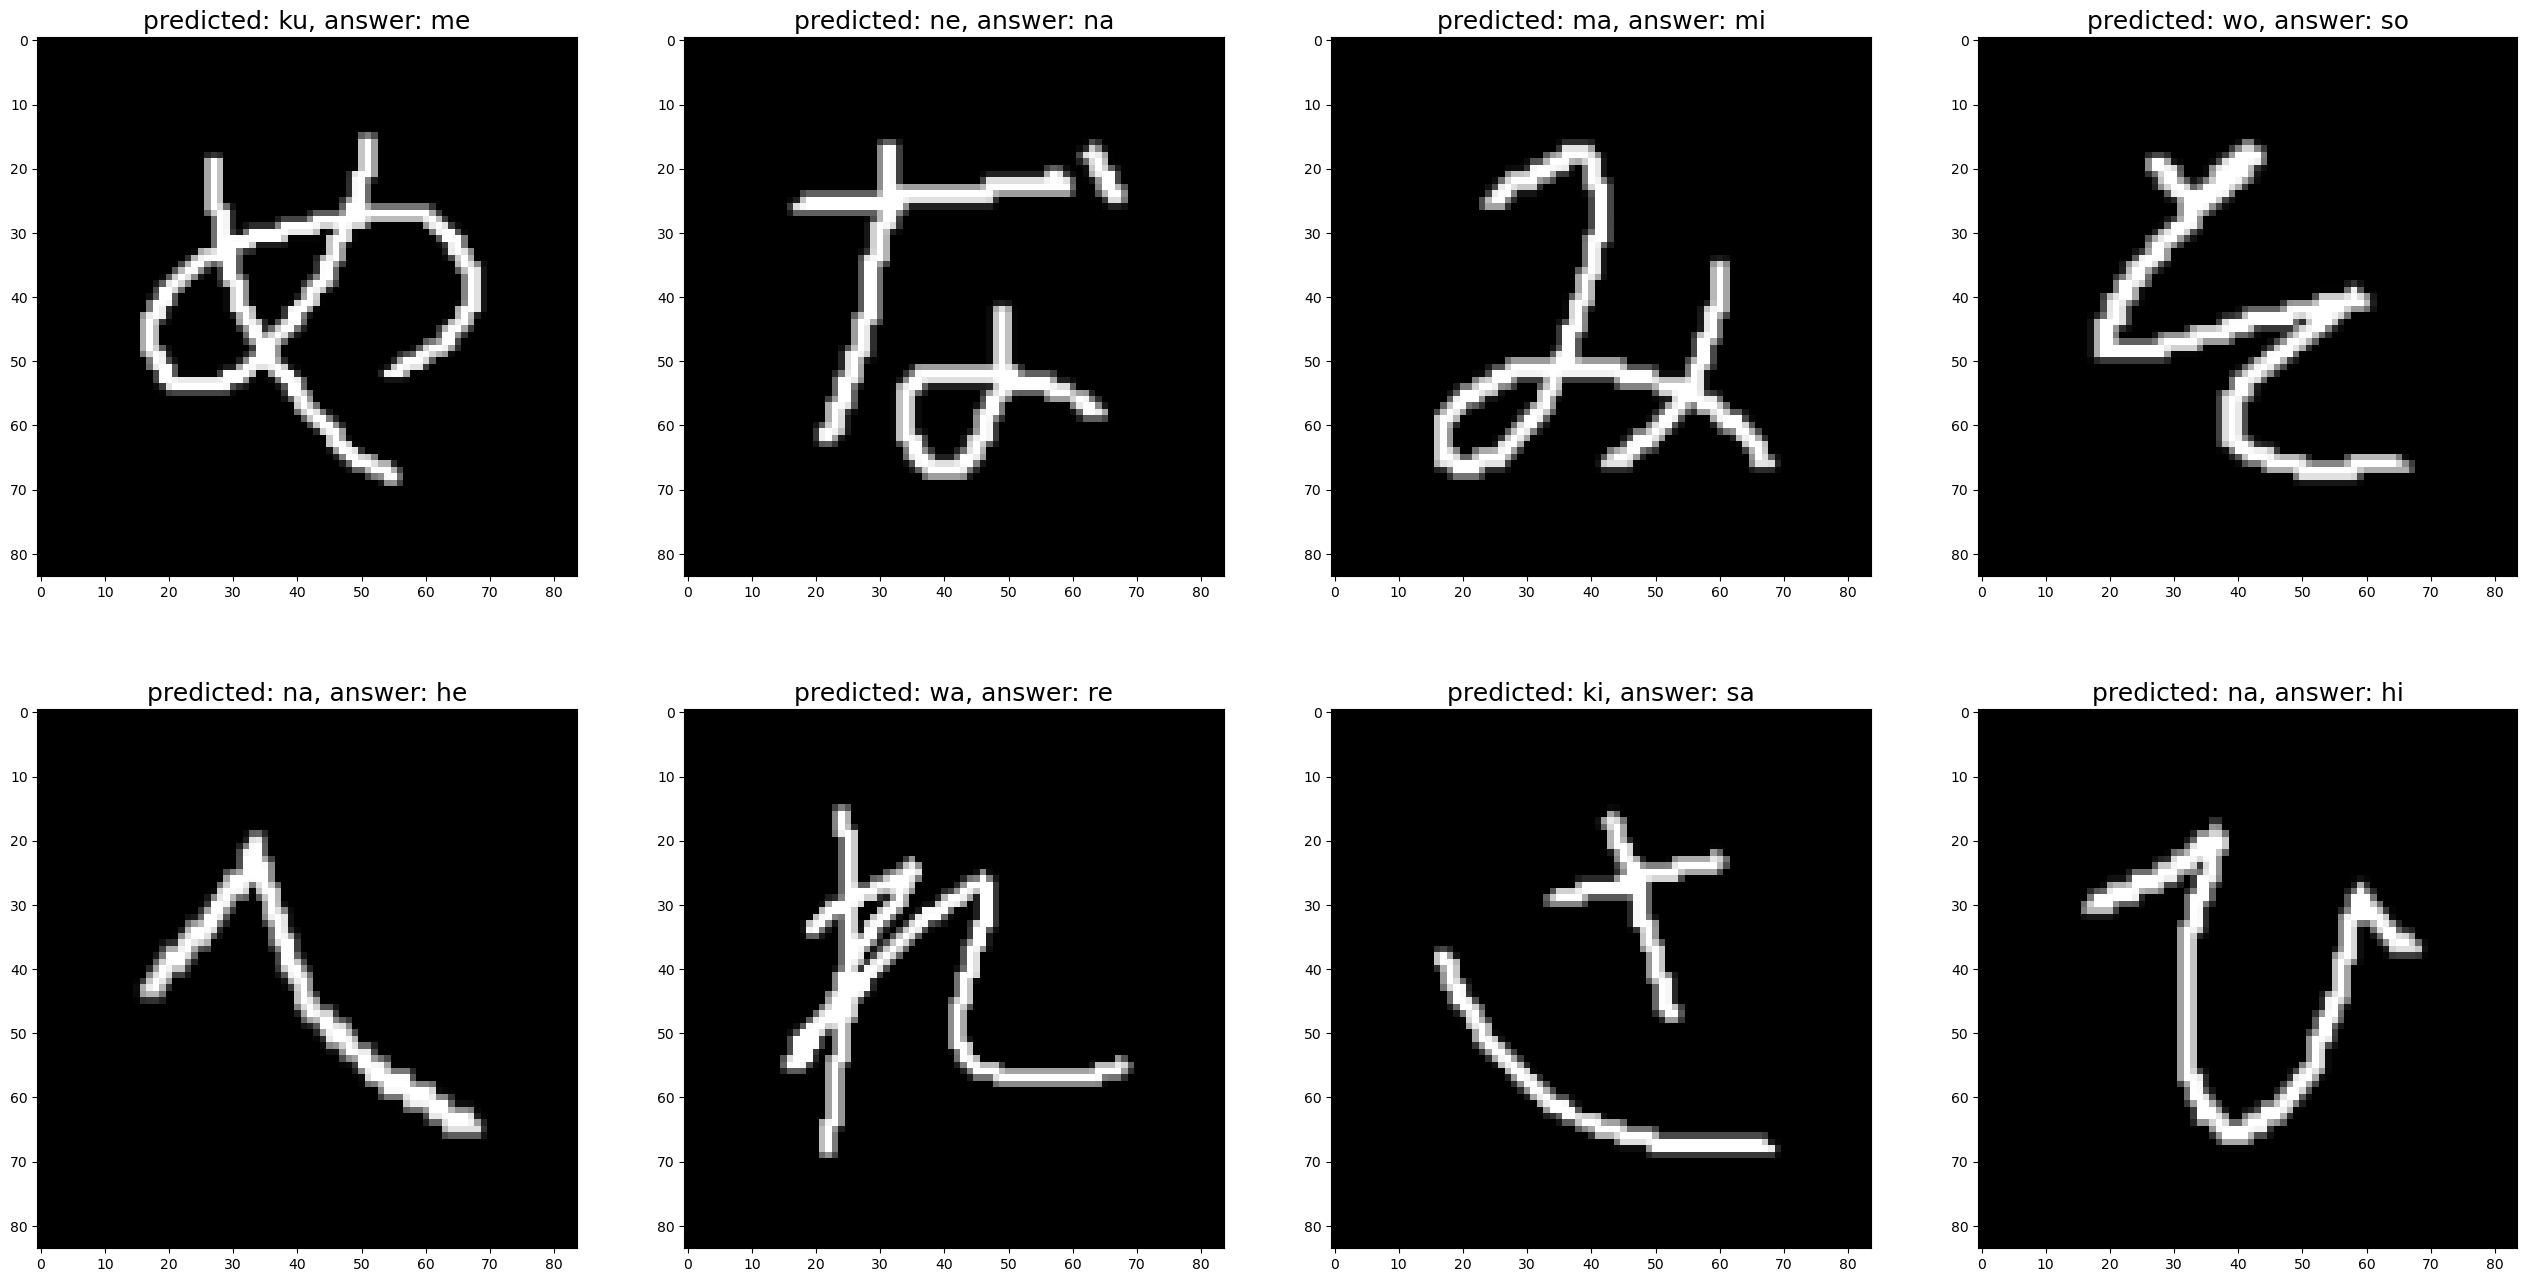

In [32]:
predictions_myhw = get_predictions(my_handwritings, model_vd)
ground_truth_myhw = np.array([romanji_dict[i] for i in answers_myhw])
# predictions_myhw, ground_truth_myhw
show_errs(my_handwritings, predictions_myhw, ground_truth_myhw, romanji_dict)